# Regression with Gradient Descent
    Momentum
    RMS Prop
    Adam

Read more at

https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/

https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c


<h5>Using Regresion in two variables x1 and x2 and y</h5>
<p>
$h(x) = w_0 + w_1 x_1+ w_2 x_2 $
  
</p> 

<h3>Gradient Descent</h3>
   Normally we update gradient as
<p>$W := W - \alpha  DW $

<h3>With Momentum</h3>
    <p>$\beta1:=0.9$
    <p>$vDW:=\beta1  (vDW) +(1-\beta1) DW$
    <p>$W := W - \alpha  (vDW) $

<h3>With RMS Prop</h3>
    <p>$\beta2:=0.99$
    <p>$sDW:=\beta2  (sDW) +(1-\beta2) (Dw)^2$
    <p>$W := W - \alpha \frac{DW}{\sqrt{sDW}}  $
 <h3>With Adam</h3>
     <p>$\beta1:=0.9$
    <p>$\beta2:=0.99$
     <p>$vDW:=\beta1 (vDW) +(1-\beta1) (DW) $
    <p>$sDW:=\beta2  (sDW) +(1-\beta2) (DW)^2 $ 
     <p> Bias Correction  
    <p>$vDWc:=\frac{vDW}{(1-\beta1^k)} $     where K is iteration 
    <p>$sDWc:=\frac{sDW}{(1-\beta2^k)} $     
    <p>$W := W - \alpha \frac{vDWc}{\sqrt{sDWc}}$
    

In [1]:
import numpy as np 
import pandas as pd 
import sklearn.utils as skutils
import sklearn.model_selection as skmodelsel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<H1>Read Data from CSV

In [2]:
import requests
import io
url="https://manmohan291.s3.ap-south-1.amazonaws.com/LinearRegressionDS/CylinderVolumeData.zip"
s=requests.get(url).content
df=pd.read_csv(io.BytesIO(s),compression='zip')

df = skutils.shuffle(df)
dfTrain, dfValid = skmodelsel.train_test_split(df, test_size=0.2)
dfTrain.head()

,radius,height,volume
4514,7.5,22.5,3976.078202
2203,2.0,11.0,138.230077
278,39.5,1.0,4901.669938
287,44.0,1.0,6082.123377
2516,8.5,12.5,2837.250865


<h5> Visualize Data

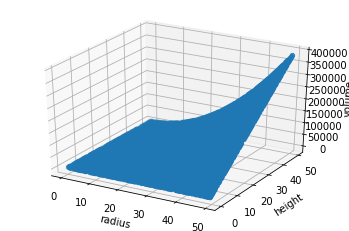

In [3]:
#%matplotlib notebook
plt3D = plt.figure().gca(projection='3d')
plt3D.scatter(dfTrain['radius'], dfTrain['height'], dfTrain['volume'])
plt3D.set_xlabel('radius')
plt3D.set_ylabel('height')
plt3D.set_zlabel('volume')
plt.show()

<h1>Extract Input Feature to <b>X </b>and Label to <b>y</b>

In [4]:
def extractFeatures(df):
    df_Features=df.loc[:,['radius','height']]
    df_Label=df.loc[:,['volume']]
    X=df_Features.values
    Y=df_Label.values
    return X,Y

<h5>Normalize Input    

In [5]:

def NormalizeInput(X,SMean,SDev):   
    XNorm=(X-SMean)/SDev
    return XNorm

##### Map Feature

In [6]:
def mapFeature(X,degree):
    sz=X.shape[1]
    if (sz==2):
        sz=(degree+1)*(degree+2)/2
        sz=int(sz)
    else:
         sz=degree+1
    out=np.ones((X.shape[0],sz))     #Adding Bias W0

    sz=X.shape[1]
    if (sz==2):
        X1=X[:, 0:1]
        X2=X[:, 1:2]
        col=1
        for i in range(1,degree+1):        
            for j in range(0,i+1):
                out[:,col:col+1]= np.multiply(np.power(X1,i-j),np.power(X2,j))    
                col+=1
        return out
    else:
        for i in range(1,degree+1):        
            out[:,i:i+1]= np.power(X,i)
    
    return out

<h1> Training

#### Preprocessing

In [22]:
degree=3
X,Y=extractFeatures(dfTrain)
SMean=np.mean(X,axis=0)    
SDev=np.std(X,axis=0)
inputX=NormalizeInput(X,SMean,SDev)

inputX=mapFeature(inputX,degree) 

Y=Y/100000


#### Initialization

In [23]:
batchSize=len(Y)         #no of Examples
epoch = 10000
alpha = 0.1
beta1=0.99
beta2=0.999
learningDecayRate=0.99998
epsilon=0.0000000001
featureCount=inputX.shape[1] 
weights=np.zeros((featureCount, 1)) #initialize Weight Paramters
#weights=np.random.rand(featureCount,1)*1000
vDW=np.zeros((featureCount, 1))
sDW=np.zeros((featureCount, 1))


<h5> Gradient Descent Updates

In [24]:
lossList=[]
for k in range(epoch):
    #nth iteration
    t=k+1
    
    #Hypothesis
    hypothesis=np.matmul( inputX,weights)           
    
    #Loss
    loss=hypothesis-Y  
    
    
    #derivative
    dW=np.matmul(inputX.T,loss)  #Derivative
   
    #learning Rate decrease as training progresses 
    #alpha=alpha*learningDecayRate
    
    #gradient Update
    vDW = (beta1) *vDW+ (1-beta1) *dW        #Momentum  
    sDW = (beta2) *sDW+ (1-beta2) *(dW**2)   #RMSProp
    
    vDWc =vDW/(1-beta1**t)
    sDWc =sDW/(1-beta2**t)
    
    weights=weights -  (alpha/batchSize)*dW     #Normal  
    #weights=weights - (alpha/batchSize)*vDW     #Momentum   
    #weights=weights - (alpha/batchSize)*dW/np.sqrt(csDW+epsilon)     #RMSProp 
    #weights=weights - (alpha/batchSize)*(vDWc/(np.sqrt(sDWc)+epsilon)) #Adam          
    
    
    #Compute Loss for Plotting
    newLoss=np.matmul( inputX,weights)-Y
    newLossSqr=np.multiply(newLoss,newLoss)
    lossList=lossList+[(1.0/(2.0*batchSize))* np.sum(newLossSqr)]

print(lossList[0],lossList[epoch-1])


0.19590770264432578 9.687705376719563e-21


<h1>Plot Loss Curve

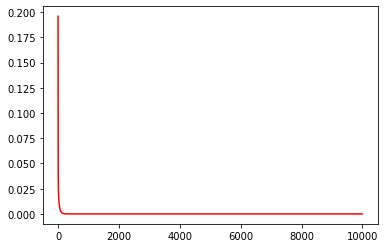

In [40]:
plt.plot(lossList,color='r')
plt.show()

#### Check Tail of Loss curve
if this is still decreasing then we need to train more.

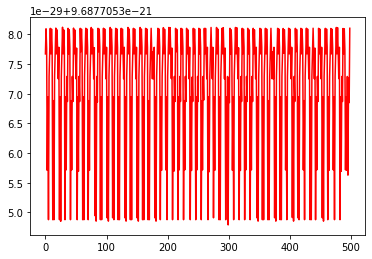

In [41]:
plt.plot(lossList[int(epoch*0.95):epoch-1],color='r')
plt.show()

<h1> Prediction/RMSE Evaluation

In [29]:
def predict(X,weights,SMean,SDev):
    inputX=NormalizeInput(X,SMean,SDev)
    inputX=mapFeature(inputX,degree) 
    PY=np.matmul(inputX, weights)
    return PY


In [30]:
def getRMSE(aY,pY):
    Error=aY- pY
    ErrorSqr=Error**2
    MSE=ErrorSqr.mean()
    RMSE=np.sqrt(MSE)
    return RMSE

##### RMSE on Training Data

In [31]:
pY=predict(X, weights,SMean,SDev)  # Predict with bias feature added
print("{0:.15f}".format(getRMSE(Y, pY)))

0.000000000139196


##### RMSE on Validation Data
RMSE on Validation should be similar to RMSE on training data.

In [32]:
vX,vY=extractFeatures(dfValid)
pY=predict(vX, weights,SMean,SDev)  # Predict with bias feature added
vY=vY/100000
print("{0:.15f}".format(getRMSE(vY, pY)))

0.000000000138765


## Visualize Model

In [33]:
x_min, x_max = X[:, 0].min() , X[:, 0].max() 
y_min, y_max = X[:, 1].min() , X[:, 1].max() 
u = np.linspace(x_min, x_max,20) 
v = np.linspace(y_min, y_max, 20) 
z = np.zeros(( len(u), len(v) )) 
U,V=np.meshgrid(u,v)
for i in range(len(u)): 
    for j in range(len(v)): 
        uv= np.column_stack((np.array([[u[i]]]),np.array([[v[j]]])))
        pv =predict(uv, weights,SMean,SDev)
        z[i,j] =pv[0][0]
z = np.transpose(z) 

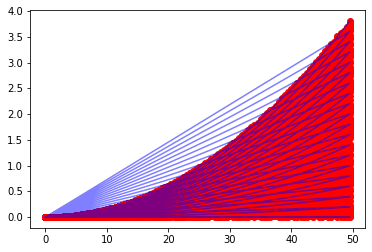

In [34]:
fig = plt.figure()
plt.scatter(X[:,0],Y,marker="o",color="r")
plt.plot(U.flatten(),z.flatten(),alpha=0.5,color='b')
plt.show()

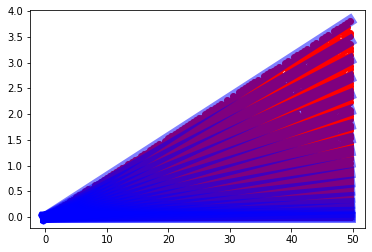

In [35]:
fig = plt.figure()
plt.scatter(X[:,1],Y,marker="o",color="r")
plt.plot(V,z,alpha=0.5,color='b',linewidth=11.0)
plt.show()

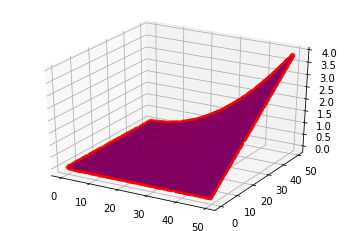

In [36]:
#%matplotlib notebook
fig = plt.figure()
plt3D = fig.add_subplot(111, projection='3d')   
plt3D.scatter(X[:,0],X[:,1],Y,marker="o",color="r")
 
plt3D.plot_surface(U,V,z,alpha=0.5,color='b')
plt.show()

#### Using algo predict volume for following values
     radius=189
     height=177
     
     Volume should be approx 19863087.12

In [37]:
pY=predict(np.array([[189,177]]), weights,SMean,SDev)  
print( pY*100000)  # Since we scaled Y while training

[[19863087.11940211]]
